In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import xgboost as xgb
import explainer
import shap
from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [2]:
# read the data
# The "validation" set plays the role of the test in the competition
# We keep their name validation here
'''
Replace the path here with your data path!
'''
path = 'Data/KDD-CUP/'
train = pd.read_csv(path+'cup98LRN.txt')
val = pd.read_csv(path+'cup98val.txt')
val_label = pd.read_csv(path+'valtargt.txt')

C:\Users\ferlo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,...,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,BOA,1,CA,91326,,,5202,0,,...,0.0,0,L,2,G,X,X,X,1.0,A
2,9001,AMH,1,NC,27017,,,0,0,,...,0.0,1,L,4,E,X,X,X,60.0,C
3,8701,BRY,0,CA,95953,,,2801,0,,...,0.0,1,L,4,E,X,X,X,41.0,C
4,8601,,0,FL,33176,,,2001,0,X,...,0.0,1,L,2,F,X,X,X,26.0,A


In [4]:
# merge the label for the validation
val = val.merge(val_label, on='CONTROLN')

In [5]:
#Unfinished
clf_train = train[["AGE", "WEALTH2",  "HIT", "MALEMILI",
         "MALEVET", "VIETVETS", "WWIIVETS", "LOCALGOV", "STATEGOV", "FEDGOV", 
         "ETH7", "ETH10", "ETH11", "AFC1", "AFC2", "AFC3", "AFC4", "AFC5", "AFC6",
         "VC1", "VC2", "VC3", "VC4", "NUMPRM12", "CARDGIFT", "TIMELAG", "AVGGIFT", "LASTGIFT"]]
reg_train = clf_train[train['TARGET_B']==1]
val = val[["AGE",  "WEALTH2",  "HIT", "MALEMILI",
         "MALEVET", "VIETVETS", "WWIIVETS", "LOCALGOV", "STATEGOV", "FEDGOV",  
         "ETH7", "ETH10", "ETH11", "AFC1", "AFC2", "AFC3", "AFC4", "AFC5", "AFC6",
         "VC1", "VC2", "VC3", "VC4", "NUMPRM12", "CARDGIFT", "TIMELAG", "AVGGIFT", "LASTGIFT"]]
train_b = train['TARGET_B']
train_d = train['TARGET_D'][train['TARGET_B']==1]
# val_b = val['TARGET_B']
# val_d = val['TARGET_D']

In [6]:
print(len(reg_train))
print(len(clf_train))
print(len(train_b))
print(len(train_d))

4843
95412
95412
4843


In [7]:
train_b.head()

0    0
1    0
2    0
3    0
4    0
Name: TARGET_B, dtype: int64

In [8]:
# unbalanced dataset
sum(train_b)/len(train_b)

0.05075881440489666

# Training

In [9]:
# For classification and regression, we use xgboost 
gclf = xgb.XGBClassifier()
gclf.fit(clf_train.values, train_b.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [10]:
np.percentile(gclf.predict_proba(val.values)[:,1], 95)

0.09054996147751808

In [11]:
# Regressor
greg = xgb.XGBRegressor()
greg.fit(reg_train.values, train_d.values)

[09:40:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [12]:
np.percentile(greg.predict(val.values),95)

33.39040260314941

# SHAP Important features 

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

Index(['VC3', 'NUMPRM12', 'WWIIVETS', 'CARDGIFT', 'VC1', 'AGE', 'TIMELAG',
       'VC4', 'VC2', 'AFC6', 'AFC5', 'AFC4', 'AFC3', 'AFC2', 'AFC1', 'ETH11',
       'ETH10', 'ETH7', 'FEDGOV', 'STATEGOV', 'LOCALGOV', 'VIETVETS',
       'MALEVET', 'MALEMILI', 'HIT', 'WEALTH2', 'AVGGIFT', 'LASTGIFT'],
      dtype='object')
[0.01995375 0.0166178  0.01377618 0.0052599  0.0040677  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


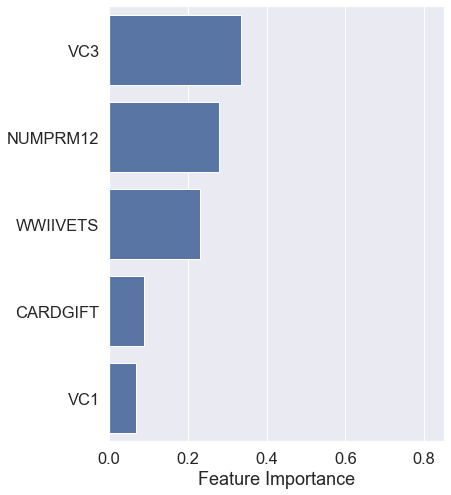

Index(['LASTGIFT', 'VC3', 'MALEVET', 'AFC5', 'AGE', 'NUMPRM12', 'VIETVETS',
       'CARDGIFT', 'STATEGOV', 'TIMELAG', 'VC4', 'WEALTH2', 'VC1', 'AFC6',
       'HIT', 'MALEMILI', 'AFC1', 'AFC2', 'ETH11', 'ETH10', 'ETH7', 'FEDGOV',
       'LOCALGOV', 'AFC3', 'AFC4', 'AVGGIFT', 'WWIIVETS', 'VC2'],
      dtype='object')
[79.54546848  6.35889438  5.1816701   5.02235345  3.08580025  1.70346652
  1.02664388  0.38783338  0.31914498  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -2.19462304 -2.59599707 -5.36090901 -8.09000535]


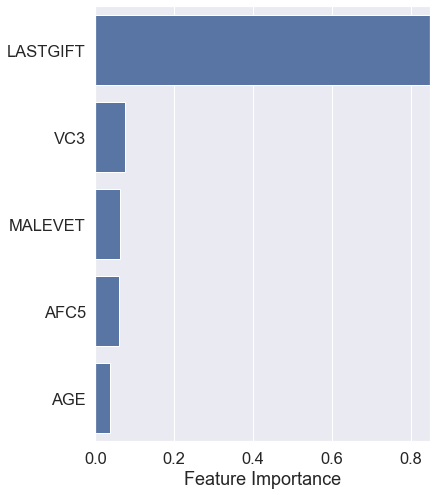

In [21]:
# Get an interesting sample (the one below is the same Xintian selected)
ix = 2511

def prob_score_func(sample):
    return gclf.predict_proba(sample)[:, 1]

import seaborn as sns
import matplotlib.pyplot as plt

def show_importance_chart(cols, shap_values, model_type):
    f, ax = plt.subplots(figsize=(6,8))
    sns.set(font_scale=1.5)
    shap_order = (-shap_values).argsort()
    shap_values = shap_values[shap_order]
    print(cols[shap_order])
    print(shap_values)
    y = cols[shap_order][:5]
    x = shap_values[:5] / shap_values.sum()
    sns.barplot(x, y, color=sns.color_palette()[0], ax=ax)
    ax.set_xlabel("Feature Importance")
    plt.xlabel("Feature Importance")
    #plt.xlabel("Most important features".format(model_type))
    plt.xlim(0, 0.85)
    plt.savefig("images/{0}.png".format(model_type), dpi=300, bbox_inches='tight')
    plt.show()

example = val.iloc[ix, :]
default = val.median()
explain = shap.KernelExplainer(prob_score_func, default.values.reshape(1, -1))
shap_values = explain.shap_values(example, nsamples=100000, l1_reg='aic')
show_importance_chart(val.columns, shap_values, "probability estimation model")

explain = shap.KernelExplainer(greg.predict, default.values.reshape(1, -1))
shap_values = explain.shap_values(example, nsamples=100000, l1_reg='aic')
show_importance_chart(val.columns, shap_values, "regression model")

In [15]:
def scoring_function(data):
    return greg.predict(data)*gclf.predict_proba(data)[:, 1]
threshold = np.percentile(scoring_function(val.values),95)
explain = explainer.Explainer(scoring_function, default, prune=False)
explanations = explain.explain(example.values.reshape(1, -1), thresholds=[threshold], max_ite=1000)
explanations

[[[6, 26, 27],
  [21, 23, 26, 27],
  [19, 23, 26, 27],
  [23, 24, 26, 27],
  [20, 23, 26, 27],
  [0, 23, 26, 27]]]

In [17]:
# Get LaTex table 1
continuous_features = val.columns
ix = 0
ix_explanations = explanations[0]
print("\\begin{{tabular}}{{{0}}}".format("S"*(1+len(ix_explanations))))
print("\\toprule")
print('&'.join(["{Explanations $\\rightarrow$}"]+ ["{{{0}}}".format(i+ 1) for i in range(len(ix_explanations))]) + "\\\\")
print("\\midrule")
features = np.unique(np.array([item for sublist in ix_explanations for item in sublist]))
for f in features:
    line = ["{{{0}}}".format(continuous_features[f].replace('_', '\_'))]
    for e in ix_explanations:
        if f in e:
            is_high = default[f] < example[f]
            change_needed = "{$\\uparrow$}" if is_high else "{$\\downarrow$}"
            line += [change_needed]
        else:
            line += [""]
    print("&".join(line) + "\\\\")
print("\\midrule") 
print("\\multicolumn{6}{l}{$\\uparrow$ means feature is too large to grant credit.} \\\\")    
print("\\multicolumn{6}{l}{$\\downarrow$ means feature is too small to grant credit.} \\\\")
print("\\bottomrule")    
print("\\end{tabular}")

\begin{tabular}{SSSSSSS}
\toprule
{Explanations $\rightarrow$}&{1}&{2}&{3}&{4}&{5}&{6}\\
\midrule
{AGE}&&&&&&{$\downarrow$}\\
{WWIIVETS}&{$\uparrow$}&&&&&\\
{VC1}&&&{$\downarrow$}&&&\\
{VC2}&&&&&{$\uparrow$}&\\
{VC3}&&{$\uparrow$}&&&&\\
{NUMPRM12}&&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}\\
{CARDGIFT}&&&&{$\uparrow$}&&\\
{AVGGIFT}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}\\
{LASTGIFT}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}&{$\uparrow$}\\
\midrule
\multicolumn{6}{l}{$\uparrow$ means feature is too large to grant credit.} \\
\multicolumn{6}{l}{$\downarrow$ means feature is too small to grant credit.} \\
\bottomrule
\end{tabular}


In [18]:
[[continuous_features[i] for i in e] for e in ix_explanations]

[['WWIIVETS', 'AVGGIFT', 'LASTGIFT'],
 ['VC3', 'NUMPRM12', 'AVGGIFT', 'LASTGIFT'],
 ['VC1', 'NUMPRM12', 'AVGGIFT', 'LASTGIFT'],
 ['NUMPRM12', 'CARDGIFT', 'AVGGIFT', 'LASTGIFT'],
 ['VC2', 'NUMPRM12', 'AVGGIFT', 'LASTGIFT'],
 ['AGE', 'NUMPRM12', 'AVGGIFT', 'LASTGIFT']]

In [19]:
example2 = example.copy()
print(scoring_function(example2))
example2.WWIIVETS = default.WWIIVETS
print(scoring_function(example2))
example2.LASTGIFT = default.LASTGIFT
print(scoring_function(example2))
example2.AVGGIFT = default.AVGGIFT
print(scoring_function(example2))

[10.31724]
[8.760098]
[2.7828085]
[1.2361804]


In [20]:
default

AGE         62.000000
WEALTH2      5.000000
HIT          0.000000
MALEMILI     0.000000
MALEVET     31.000000
VIETVETS    29.000000
WWIIVETS    32.000000
LOCALGOV     6.000000
STATEGOV     3.000000
FEDGOV       2.000000
ETH7         0.000000
ETH10        0.000000
ETH11        0.000000
AFC1         0.000000
AFC2         0.000000
AFC3         0.000000
AFC4        15.000000
AFC5        31.000000
AFC6         1.000000
VC1         30.000000
VC2         18.000000
VC3         32.000000
VC4          9.000000
NUMPRM12    12.000000
CARDGIFT     4.000000
TIMELAG      6.000000
AVGGIFT     11.666667
LASTGIFT    15.000000
dtype: float64